##### import libs

In [1]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from copy import deepcopy
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split

from utils import load_data, evaluate, plot_feature_importances, make_val_testlike

##### load data

In [2]:
user_item_data, user_meta_data, item_meta_data, test_pairs_data = load_data()

In [2]:
user_item_data_w_group_features = pd.read_parquet(
    "data/user_item_data_w_group_features.parquet"
)

In [4]:
test_pairs_data_w_group_features = pd.read_parquet(
    "data/test_pairs_data_w_group_features.parquet"
)

In [3]:
columns = list(
    set(user_item_data_w_group_features.columns.to_list())
    - set(
        [
            "bookmarks",
            "dislike",
            "explicit",
            "like",
            "share",
            "timespent",
        ]
    )
)

In [ ]:
set(test_pairs_data_w_group_features.columns) == set(columns)

In [5]:
target = "explicit"

In [6]:
shape = user_item_data_w_group_features.shape

In [7]:
train_size = int(10e6)
val_size = int(shape[0] * 0.15)

In [8]:
user_item_data_w_group_features = user_item_data_w_group_features[
    -(train_size + val_size) :
]

train_df, val_df = train_test_split(
    user_item_data_w_group_features[columns + [target]],
    test_size=0.15,
    random_state=42,
    shuffle=False,
)

In [9]:
val_df = user_item_data_w_group_features[columns + [target]][
    -int(len(user_item_data_w_group_features) * 0.15) :
]

In [10]:
train_df = user_item_data_w_group_features[columns + [target]][
    -int(len(user_item_data_w_group_features) * 0.15) - int(10e6) : -int(
        len(user_item_data_w_group_features) * 0.15
    )
]

##### catboost

In [14]:
model = CatBoostClassifier(
    verbose=True,
    iterations=1000,
    auto_class_weights="SqrtBalanced",
    cat_features=["user_id", "source_id", "item_id"],
)

In [ ]:
model.fit(train_df[-int(10e6) :][columns], train_df[-int(10e6) :][target])

In [14]:
model.classes_

array([-1,  0,  1])

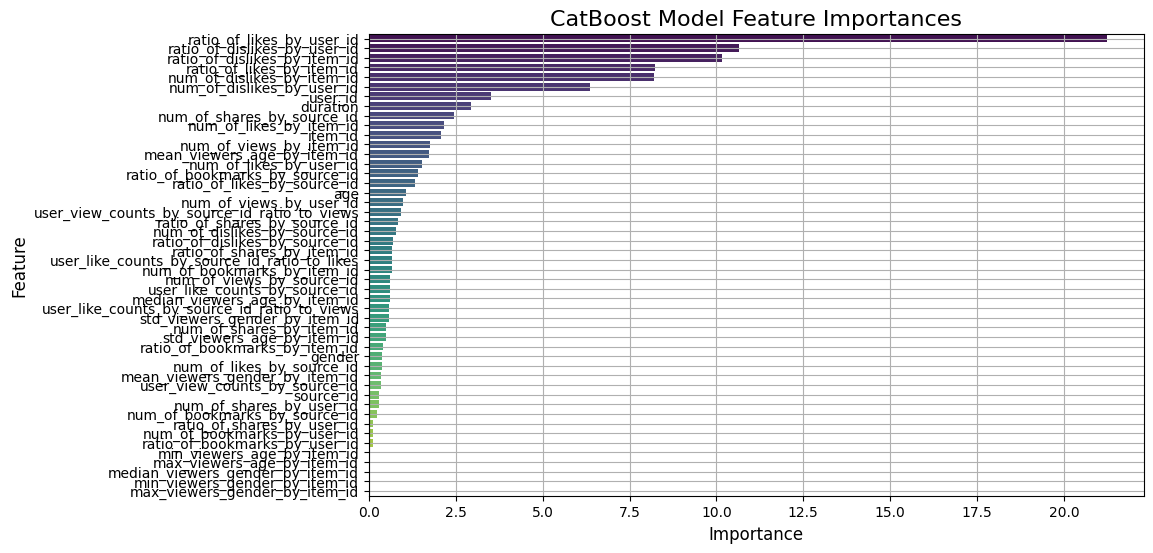

In [15]:
plot_feature_importances(model, graphic=True)

In [2]:
from catboost import CatBoostRanker
model = CatBoostRanker(
    verbose=True,
)
model.load_model("ranker")

In [16]:
catboost_proba = model.predict_proba(val_df[columns])

In [ ]:
evaluate(val_df.user_id.values, val_df[target].values, catboost_proba[:, 1])

100%|██████████| 181721/181721 [00:49<00:00, 3708.03it/s]


0.6516163506855832

### submission

In [10]:
model = CatBoostClassifier(
    verbose=False,
    iterations=1000,
    auto_class_weights="SqrtBalanced",
    cat_features=["user_id", "source_id", "item_id"],
)

In [11]:
model.fit(
    user_item_data_w_group_features[-int(10e6) :][columns],
    user_item_data_w_group_features[-int(10e6) :][target],
)

: 

In [7]:
model.load_model("classifier")

In [9]:
test_proba = model.predict_proba(test_pairs_data_w_group_features[model.feature_names_])

In [13]:
test_pairs_data["predict"] = test_proba[:, 1]
test_pairs_data.to_csv("submissions/cbc_group_fs_cat_submission.csv", index=False)

: 